In [1]:
# processing
import math
import scipy.stats as stats
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

In [2]:
def find_center(df):
    x = df['posX']
    y = df['posY']
    data = np.vstack((x, y))

    kde = stats.kde.gaussian_kde(data)
    gx, gy = np.mgrid[x.min():x.max():128j, y.min():y.max():128j]
    gxy = np.dstack((gx, gy)) # shape is (128, 128, 2)
    z = np.apply_along_axis(kde, 2, gxy)
    z = z.reshape(128, 128)

    center_ix, center_iy = np.unravel_index(z.argmax(), z.shape)
    center_x = center_ix / 128 * (x.max() - x.min()) + x.min()
    center_y = center_iy / 128 * (y.max() - y.min()) + y.min()
    return center_x, center_y

In [3]:
def find_circle(x, xc, yc, r):
    y_upper = yc + np.sqrt(r**2 - (x - xc)**2)
    y_lower = yc - np.sqrt(r**2 - (x - xc)**2)
    return y_upper, y_lower

In [4]:
def in_circle(row, xc_2, yc_2, R_2):
    x_coord = row['posX']
    if x_coord < (xc_2 - R_2) or x_coord > (xc_2 + R_2):
        return 0
    else:
        upper_bound, lower_bound = find_circle(x_coord, xc_2, yc_2, R_2)
        y_coord = row['posY']
        if y_coord > upper_bound or y_coord < lower_bound:
            return 0
        else:
            return 1

In [5]:
def get_alpha(dirX, dirY, L):
    alpha = L/2 / math.sqrt(dirX**2 + dirY**2)
    return alpha

In [6]:
def get_end_coords(posX, posY, dirX, dirY, alpha):
    startX = posX - alpha * dirX
    startY = posY - alpha * dirY
    return startX, startY

In [7]:
def get_nodes(posX, posY, dirX, dirY, L):
    alpha = get_alpha(dirX, dirY, L)
    startX, startY = get_end_coords(posX, posY, dirX, dirY, alpha)
    segmentX = 2 * alpha * dirX / L
    segmentY = 2 * alpha * dirY / L

    nodes = [(startX, startY)]
    for i in range(1, L+1):
        nodeX = startX + i * segmentX
        nodeY = startY + i * segmentY
        nodes.append((nodeX, nodeY))

    return nodes

In [8]:
def cartesian_dist(n1, n2):
    return math.sqrt((n1[0] - n2[0])**2 + (n1[1] - n2[1])**2)

In [9]:
def get_min_dist(nodes1, nodes2):
    min_dist = 10**6
    for n1 in nodes1:
        for n2 in nodes2:
            d = cartesian_dist(n1, n2)
            if d < min_dist:
                min_dist = d
    return min_dist

In [10]:
def get_mean_min_dist(df):
    microtubules = []
    for index, row in df.iterrows():
        posX = row['posX']
        posY = row['posY']
        dirX = row['dirX']
        dirY = row['dirY']
        L = int(row['length'])
        nodes = get_nodes(posX, posY, dirX, dirY, L)
        microtubules.append(nodes)
    
    list_min_dist = []
    for i, nodes1 in enumerate(microtubules):
        for j, nodes2 in enumerate(microtubules[(i+1):]):
            min_dist = get_min_dist(nodes1, nodes2)
            list_min_dist.append(min_dist)
    
    return np.mean(list_min_dist)

In [11]:
df = pd.read_table('~/thomsonlab/simulation/ms-simulations/1d-phase/testruns/run0019/fiber_position.txt',
                skiprows=5,
                delim_whitespace=True,
                names=['class', 'identity', 'length', 'posX', 'posY', 'dirX', 'dirY', 'endToEnd', 'cosinus', 'organizer'])
df = df.dropna(how='any')

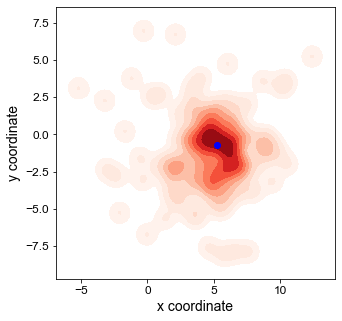

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
fig.patch.set_facecolor('white')
ax.set_xlabel('x coordinate', fontsize=14)
ax.set_ylabel('y coordinate', fontsize=14)

sns.kdeplot(x=df['posX'], y=df['posY'], cmap="Reds", shade=True, bw_adjust=.5)

center_x, center_y = find_center(df)
ax.scatter([center_x], [center_y], color='blue')

plt.show()

In [13]:
aster_fraction = []
mean_min_dist = []
for i in range(0, 20):
    num_zeros = 4 - len(str(i))
    fpath = '~/thomsonlab/simulation/ms-simulations/1d-phase/testruns/run{}/fiber_position.txt'.format(num_zeros * '0' + str(i))
    
    df = pd.read_table(fpath,
                skiprows=5,
                delim_whitespace=True,
                names=['class', 'identity', 'length', 'posX', 'posY', 'dirX', 'dirY', 'endToEnd', 'cosinus', 'organizer'])
    df = df.dropna(how='any')

    center_x, center_y = find_center(df)

    #df_short = df[df.length <= 5]
    col = df.apply(in_circle, args=(center_x, center_y, 5), axis=1)
    df = df.assign(in_circle=col.values)

    aster_fraction.append(sum(df['in_circle']) / len(df))
    mean_min_dist.append(get_mean_min_dist(df))

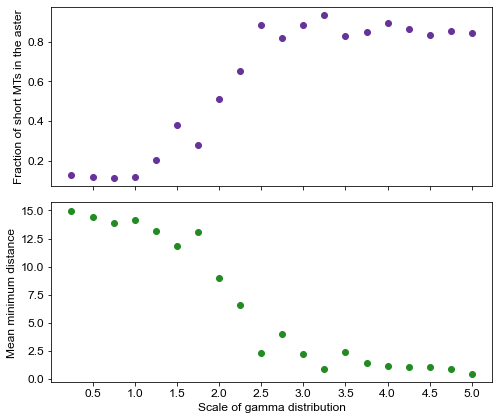

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True)
ax1, ax2 = axes
fig.patch.set_facecolor('white')

scale = np.arange(0.25, 5.1, 0.25)
ax1.scatter(scale, aster_fraction, color='rebeccapurple')
ax1.set_xticks(np.arange(0.5, 5.1, 0.5))
ax1.set_ylabel('Fraction of short MTs in the aster')

ax2.scatter(scale, mean_min_dist, color='forestgreen')
ax2.set_xlabel('Scale of gamma distribution')
ax2.set_ylabel('Mean minimum distance')

plt.tight_layout()
plt.show()